In [1]:
ENV["LINES"], ENV["COLUMNS"] = 100, 100
using BenchmarkTools
using Distributions
using LinearAlgebra
using Optim
using Printf
using QuadGK
using Random
Random.seed!(4649373)
using Roots
using SpecialFunctions
using StaticArrays
using StatsBase
using StatsFuns
using StatsPlots
default(fmt = :png, titlefontsize = 10, size = (400, 250))
using SymPy


(process:32324): GLib-GIO-WARNING **: 17:44:53.042: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.5.15.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs


In [2]:
# Override the Base.show definition of SymPy.jl:
# https://github.com/JuliaPy/SymPy.jl/blob/29c5bfd1d10ac53014fa7fef468bc8deccadc2fc/src/types.jl#L87-L105

@eval SymPy function Base.show(io::IO, ::MIME"text/latex", x::SymbolicObject)
    print(io, as_markdown("\\displaystyle " * sympy.latex(x, mode="plain", fold_short_frac=false)))
end
@eval SymPy function Base.show(io::IO, ::MIME"text/latex", x::AbstractArray{Sym})
    function toeqnarray(x::Vector{Sym})
        a = join(["\\displaystyle " * sympy.latex(x[i]) for i in 1:length(x)], "\\\\")
        """\\left[ \\begin{array}{r}$a\\end{array} \\right]"""
    end
    function toeqnarray(x::AbstractArray{Sym,2})
        sz = size(x)
        a = join([join("\\displaystyle " .* map(sympy.latex, x[i,:]), "&") for i in 1:sz[1]], "\\\\")
        "\\left[ \\begin{array}{" * repeat("r",sz[2]) * "}" * a * "\\end{array}\\right]"
    end
    print(io, as_markdown(toeqnarray(x)))
end

In [3]:
x ⪅ y = x < y || x ≈ y

mypdf(dist, x) = pdf(dist, x)
mypdf(dist::DiscreteUnivariateDistribution, x) = pdf(dist, round(x))

distname(dist::Distribution) = replace(string(dist), r"{.*}" => "")
myskewness(dist) = skewness(dist)
mykurtosis(dist) = kurtosis(dist)
function standardized_moment(dist::ContinuousUnivariateDistribution, m)
    μ, σ = mean(dist), std(dist)
    quadgk(x -> (x - μ)^m * pdf(dist, x), extrema(dist)...)[1] / σ^m
end
myskewness(dist::MixtureModel{Univariate, Continuous}) = standardized_moment(dist, 3)
mykurtosis(dist::MixtureModel{Univariate, Continuous}) = standardized_moment(dist, 4) - 3

mykurtosis (generic function with 2 methods)

In [4]:
function plot_binomial_clt(n, p, s = 1; c = 4.5)
    μ, σ = n*p, √(n*p*(1-p))
    xlim = (μ-c*σ, μ+c*σ)
    plot(x -> mypdf(Binomial(n, p), x), xlim...; label="Binomial(n,p)")
    plot!(Normal(μ, σ), xlim...; label="Normal(μ,σ)", lw=2)
    # plot!(x -> mypdf(Poisson(μ), x), xlim...; label="Poisson(μ)", ls=:dash)
    title!("n = $n, p = $p, μ=np, σ²=np(1-p)")
    plot!(; xtick=0:s:n)
end

plot_binomial_clt (generic function with 2 methods)

必修重要問題:二項分布の正規分布近似を使った確率の近似計算1

In [5]:
n, p = 100, 1/2

(100, 0.5)

In [6]:
# (1)
p_B = cdf(Binomial(n, p), 40)

0.02844396682049039

In [7]:
# (2)
q_N = cdf(Normal(n*p, √(n*p*(1-p))), 40)

0.022750131948179205

julia言語による視覚化

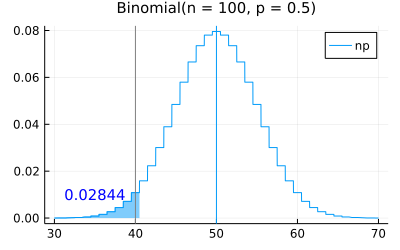

In [8]:
# (1)
plot(x -> mypdf(Binomial(n, p), x), 30, 70; label="", c=1)
vline!([n*p]; label="np", c=1)
plot!(x -> mypdf(Binomial(n, p), x), 30, 40.5;
    label="", fillrange=0, c=1, alpha=0.5)
prob = cdf(Binomial(n, p), 40)
annotate!(35, 0.01, text(@sprintf("%0.5f", prob), 10, :blue))
vline!([40]; label="", c=:gray)
title!("Binomial(n = $n, p = $p)")

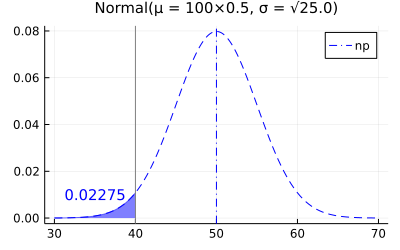

In [9]:
# (2)
plot(x -> mypdf(Normal(n*p, √(n*p*(1-p))), x), 30, 70; label="", c=:blue, ls=:dash)
vline!([n*p]; label="np", ls=:dashdot, c=:blue)
plot!(x -> mypdf(Normal(n*p, √(n*p*(1-p))), x), 30, 40;
    label="", fillrange=0, c=:blue, alpha=0.5)
prob = cdf(Normal(n*p, √(n*p*(1-p))), 40)
annotate!(35, 0.01, text(@sprintf("%0.5f", prob), 10, :blue))
vline!([40]; label="", c=:gray)
title!("Normal(μ = $n×$p, σ = √$(n*p*(1-p)))")

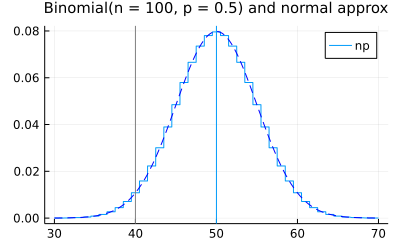

In [10]:
# (1) and (2)
plot(x -> mypdf(Binomial(n, p), x), 30, 70; label="", c=1)
vline!([n*p]; label="np", c=1)

plot!(x -> mypdf(Normal(n*p, √(n*p*(1-p))), x), 30, 70;
    label="", c=:blue, ls=:dash)
#vline!([n*p]; label="np", ls=:dashdot, c=:blue)

vline!([40]; label="", c=:gray)
title!("Binomial(n = $n, p = $p) and normal approx")

必修自習問題:二項分布の正規分布を使った確率の近似計算2

In [11]:
n, p = 8, 0.3
[
    [cdf(Binomial(n, p), k) for k in 0:n-1]'
    [ccdf(Beta(k+1, n-k), p) for k in 0:n-1]'
]

2×8 Matrix{Float64}:
 0.057648  0.255298  0.551774  0.805896  0.942032  0.988708  0.99871  0.999934
 0.057648  0.255298  0.551774  0.805896  0.942032  0.988708  0.99871  0.999934

In [12]:
n, p = 8, 0.3
[
    [ccdf(Binomial(n, p), k-1) for k in 1:n]'
    [cdf(Beta(k, n-k+1), p) for k in 1:n]'
]

2×8 Matrix{Float64}:
 0.942352  0.744702  0.448226  0.194104  0.0579676  0.0112922  0.00129033  6.561e-5
 0.942352  0.744702  0.448226  0.194104  0.0579676  0.0112922  0.00129033  6.561e-5

In [13]:
n, k = 100, 40
α = 0.05

0.05

In [14]:
# (1)
p_U = quantile(Beta(k+1, n-k), 1 - α/2)

0.5027908495776652

In [15]:
# (1)検算
cdf(Binomial(n, p_U), k)

0.02499999999999997

In [16]:
# (2)
p_L = quantile(Beta(k, n-k+1), α/2)

0.3032947687028774

In [17]:
# (2)検算
ccdf(Binomial(n, p_L), k-1)

0.025000000000000005

In [18]:
p̂ = k/n

0.4

In [19]:
σ̂² = n*p̂*(1-p̂)

24.0

In [20]:
σ̂ = √σ̂²

4.898979485566356

In [21]:
# z_{α/2}
z = quantile(Normal(0, 1), 1 - α/2)

1.9599639845400576

In [22]:
# (3)
q_U = (k + z*σ̂)/n

0.4960182335271064

In [23]:
# (3)検算
cdf(Normal(n*q_U, σ̂), k)

0.024999999999999776

In [24]:
# (4)
q_L = (k - z*σ̂)/n

0.3039817664728936

In [25]:
# (4)検算
1 - cdf(Normal(n*q_L, σ̂), k)

0.0249999999999998

julia言語による視覚化

In [26]:
n, k, α = 100, 40, 0.05
p̂ = k/n
σ̂² = n*p̂*(1-p̂)
σ̂ = √σ̂²

p_U = quantile(Beta(k+1, n-k), 1 - α/2)
p_L = quantile(Beta(k, n-k+1), α/2)
z = quantile(Normal(0, 1), 1 - α/2)
q_U = (k + z*σ̂)/n
q_L = (k - z*σ̂)/n;

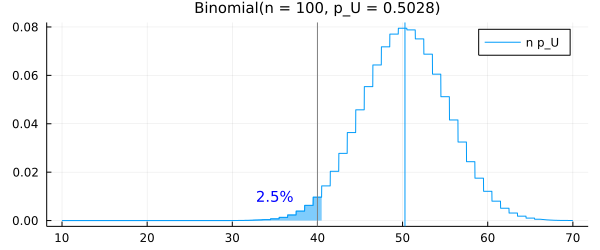

In [27]:
# (1)
plot(x -> mypdf(Binomial(n, p_U), x), 10, 70; label="", c=1)
vline!([n*p_U]; label="n p_U", c=1)
plot!(x -> mypdf(Binomial(n, p_U), x), 10, 40.5;
    label="", fillrange=0, c=1, alpha=0.5)
annotate!(35, 0.01, text("2.5%", 10, :blue))
vline!([40]; label="", c=:gray)
title!("Binomial(n = $n, p_U = $(@sprintf "%.4f" p_U))")
plot!(; size=(600, 250))

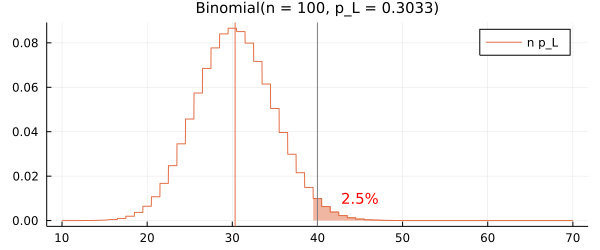

In [28]:
# (2)
plot(x -> mypdf(Binomial(n, p_L), x), 10, 70; label="", c=2)
vline!([n*p_L]; label="n p_L", c=2)
plot!(x -> mypdf(Binomial(n, p_L), x), 39.5, 70;
    label="", fillrange=0, c=2, alpha=0.5)
annotate!(45, 0.01, text("2.5%", 10, :red))
vline!([40]; label="", c=:gray)
title!("Binomial(n = $n, p_L = $(@sprintf "%.4f" p_L))")
plot!(; size=(600, 250))

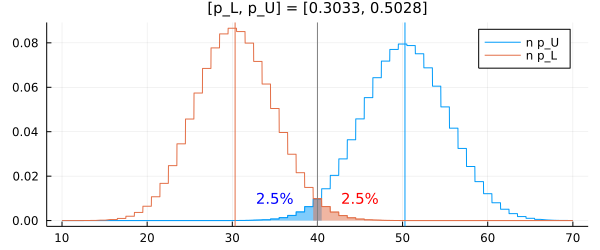

In [29]:
# (1) and (2)
plot(x -> mypdf(Binomial(n, p_U), x), 10, 70; label="", c=1)
vline!([n*p_U]; label="n p_U", c=1)
plot!(x -> mypdf(Binomial(n, p_U), x), 10, 40.5;
    label="", fillrange=0, c=1, alpha=0.5)
annotate!(35, 0.01, text("2.5%", 10, :blue))

plot!(x -> mypdf(Binomial(n, p_L), x), 10, 70; label="", c=2)
vline!([n*p_L]; label="n p_L", c=2)
plot!(x -> mypdf(Binomial(n, p_L), x), 39.5, 70;
    label="", fillrange=0, c=2, alpha=0.5)
annotate!(45, 0.01, text("2.5%", 10, :red))

vline!([40]; label="", c=:gray)
title!("[p_L, p_U] = [$(@sprintf "%.4f" p_L), $(@sprintf "%.4f" p_U)]")
plot!(; size=(600, 250))

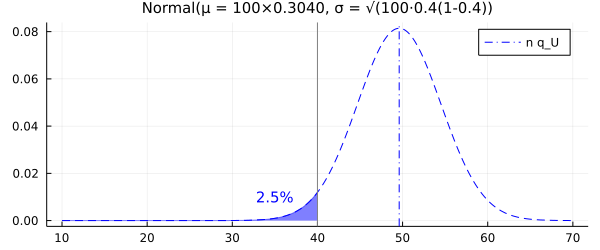

In [30]:
# (3)
plot(x -> mypdf(Normal(n*q_U, σ̂), x), 10, 70; label="", c=:blue, ls=:dash)
vline!([n*q_U]; label="n q_U", ls=:dashdot, c=:blue)
plot!(x -> mypdf(Normal(n*q_U, σ̂), x), 10, 40;
    label="", fillrange=0, c=:blue, alpha=0.5)
annotate!(35, 0.01, text("2.5%", 10, :blue))
vline!([40]; label="", c=:gray)
title!("Normal(μ = $(n)×$(@sprintf "%.4f" q_L), σ = √($n⋅$p̂(1-$p̂))")
plot!(; size=(600, 250))

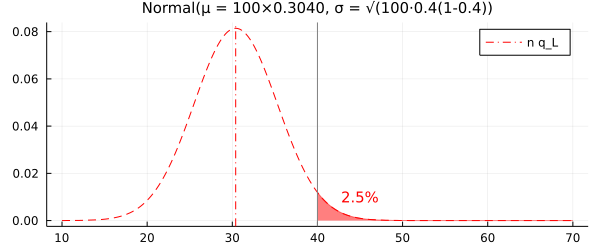

In [31]:
# (4)
plot(x -> mypdf(Normal(n*q_L, σ̂), x), 10, 70; label="", c=:red, ls=:dash)
vline!([n*q_L]; label="n q_L", ls=:dashdot, c=:red)
plot!(x -> mypdf(Normal(n*q_L, σ̂), x), 40, 70;
    label="", fillrange=0, c=:red, alpha=0.5)
annotate!(45, 0.01, text("2.5%", 10, :red))
vline!([40]; label="", c=:gray)
title!("Normal(μ = $(n)×$(@sprintf "%.4f" q_L), σ = √($n⋅$p̂(1-$p̂))")
plot!(; size=(600, 250))

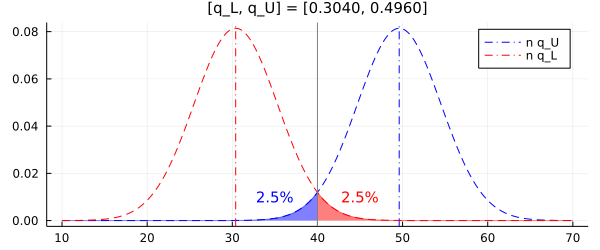

In [32]:
# (3) and (4)
plot(x -> mypdf(Normal(n*q_U, σ̂), x), 10, 70; label="", c=:blue, ls=:dash)
vline!([n*q_U]; label="n q_U", ls=:dashdot, c=:blue)
plot!(x -> mypdf(Normal(n*q_U, σ̂), x), 10, 40;
    label="", fillrange=0, c=:blue, alpha=0.5)
annotate!(35, 0.01, text("2.5%", 10, :blue))

plot!(x -> mypdf(Normal(n*q_L, σ̂), x), 10, 70; label="", c=:red, ls=:dash)
vline!([n*q_L]; label="n q_L", ls=:dashdot, c=:red)
plot!(x -> mypdf(Normal(n*q_L, σ̂), x), 40, 70;
    label="", fillrange=0, c=:red, alpha=0.5)
annotate!(45, 0.01, text("2.5%", 10, :red))

vline!([40]; label="", c=:gray)
title!("[q_L, q_U] = [$(@sprintf "%.4f" q_L), $(@sprintf "%.4f" q_U)]")
plot!(; size=(600, 250))

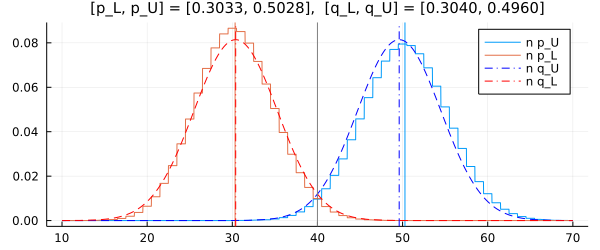

In [33]:
# (1)(2)(3)(4)
plot(x -> mypdf(Binomial(n, p_U), x), 10, 70; label="", c=1)
vline!([n*p_U]; label="n p_U", c=1)

plot!(x -> mypdf(Binomial(n, p_L), x), 10, 70; label="", c=2)
vline!([n*p_L]; label="n p_L", c=2)

plot!(x -> mypdf(Normal(n*q_U, σ̂), x), 10, 70; label="", c=:blue, ls=:dash)
vline!([n*q_U]; label="n q_U", ls=:dashdot, c=:blue)

plot!(x -> mypdf(Normal(n*q_L, σ̂), x), 10, 70; label="", c=:red, ls=:dash)
vline!([n*q_L]; label="n q_L", ls=:dashdot, c=:red)

vline!([40]; label="", c=:gray)
title!("[p_L, p_U] = [$(@sprintf "%.4f" p_L), $(@sprintf "%.4f" p_U)]"*
    ",  [q_L, q_U] = [$(@sprintf "%.4f" q_L), $(@sprintf "%.4f" q_U)]")
plot!(; size=(600, 250))